In [1]:
!pip install xgboost --quiet

In [2]:
# Data handling
import pandas as pd
from google.colab import files

# numerical calculation
import numpy as np

# Utilities
import sys, os
import re

# NLP toolkits
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,LancasterStemmer

# Tranditional modelling
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Tools & Evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from textblob import TextBlob
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from wordcloud import WordCloud
import warnings
import logging
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

nltk.download('reuters') # Downloading corpus
nltk.download('stopwords') # Downloading stopwords
nltk.download('punkt') # Downloading tokenizer
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Greatlearning notebooks/Capstone project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Greatlearning notebooks/Capstone project


In [4]:
logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
pd.set_option('display.max_colwidth', 0)
#print(Path('app.log').read_text())

## Read ticket data file as data frame

In [5]:
ticket_df = pd.read_excel('input_data.xlsx')

# Show head of the data

In [6]:
ticket_df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


# Shape of the data

In [7]:
ticket_df.shape

(8500, 4)

## Describe data

In [8]:
ticket_df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


Ticket dataset divided into 2 parts. Dependent features like Short Description, Description and Caller; 
Target variable is Assignment group

# Find any Null values in the data 

In [9]:
ticket_df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [10]:
ticket_df = ticket_df.fillna("")

In [11]:
ticket_df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

## Find any duplicate rows in the dataframe

In [12]:
duplicate = ticket_df[ticket_df.duplicated()]
duplicate.shape

(83, 4)

In [13]:
ticket_df.drop_duplicates(inplace=True)
ticket_df.shape

(8417, 4)

#### Observations:
* The ticket dataset contains 8500 rows and 4 columns
* All 4 columns are of type 'Object'with text information
* There are 9 null values in Short description and 1 null in Description columns
* We have 83 duplicate rows in the dataset

## Analyze the distribution of Assignment Group

In [14]:
targetClassCnt=ticket_df['Assignment group'].value_counts()
targetClassCnt.head()

GRP_0     3934
GRP_8     645 
GRP_24    285 
GRP_12    257 
GRP_9     252 
Name: Assignment group, dtype: int64

In [15]:
targetClassCnt.describe()

count    74.000000  
mean     113.743243 
std      460.731077 
min      1.000000   
25%      5.250000   
50%      26.000000  
75%      81.000000  
max      3934.000000
Name: Assignment group, dtype: float64

In Target variable 'Assignment group', GRP_0 has maximum rows.

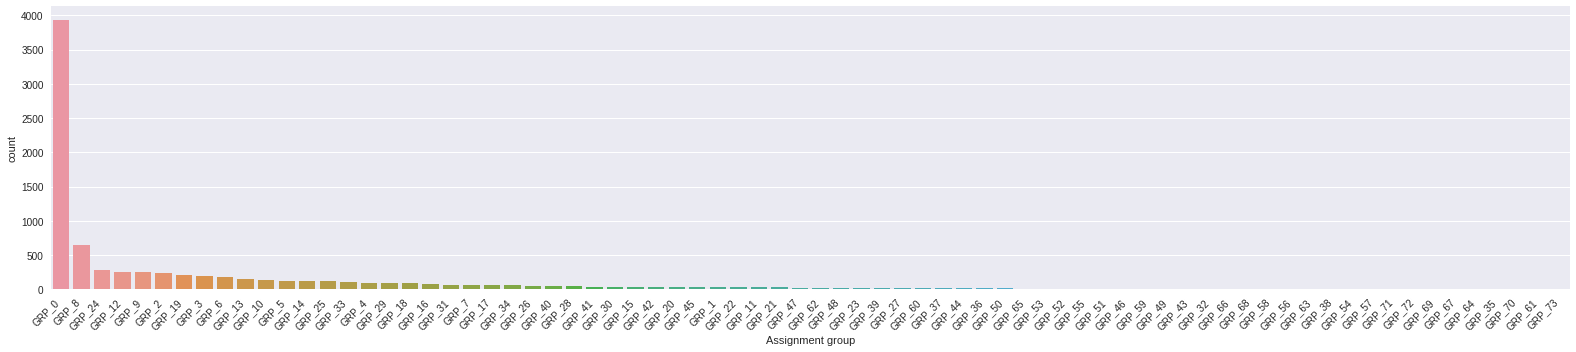

In [16]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups

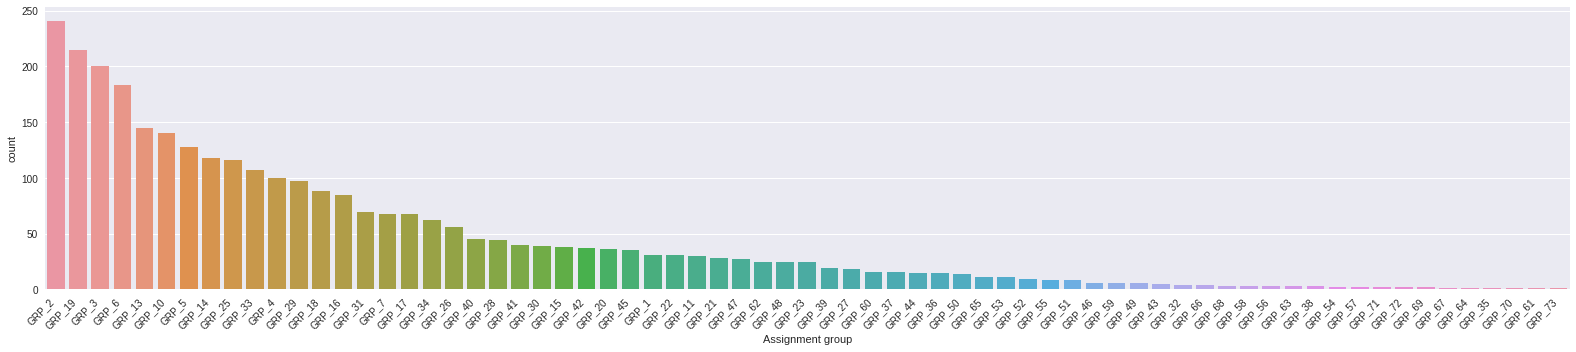

In [17]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[5:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups excluding top 5

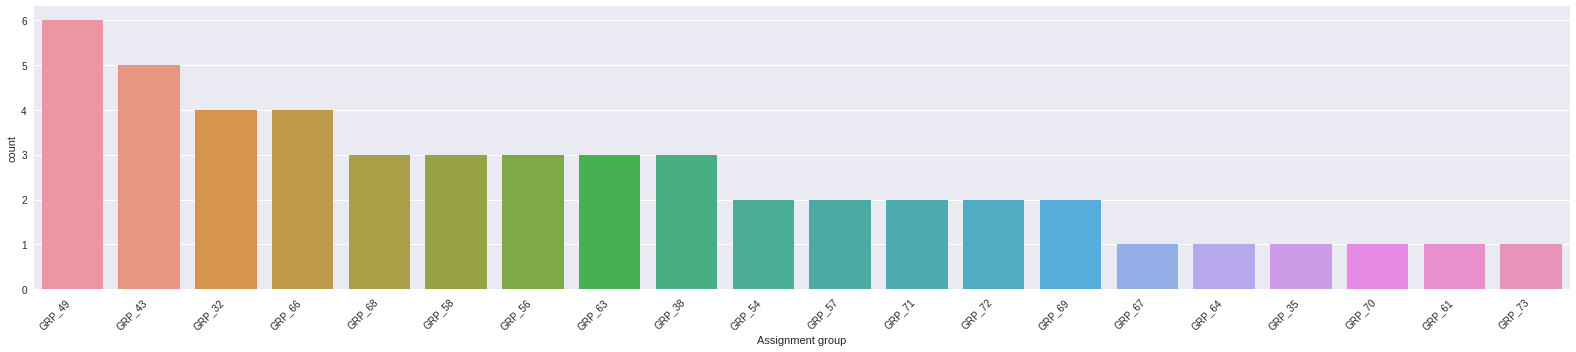

In [18]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[-20:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of bottom most 20 assignment groups .

As there are groups with just one ticket, we can club together all groups with less than 3 records into one group and analyze the data

In [19]:
asnGroupBy = ticket_df.groupby(['Assignment group'])
others=[]
for grp in ticket_df['Assignment group'].unique():
  if(asnGroupBy.get_group(grp).shape[0]<5):
    others.append(grp)
print('Found {} groups which have under 5 samples'.format(len(others)))
ticket_df['Assignment group']=ticket_df['Assignment group'].apply(lambda x : 'OTHERS' if x in others  else x)

ticket_df['Assignment group'].unique()

Found 18 groups which have under 5 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'OTHERS', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45',
       'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50', 'GRP_51',
       'GRP_52', 'GRP_53', 'GRP_55', 'GRP_59', 'GRP_60', 'GRP_62',
       'GRP_65'], dtype=object)

## Analyse the distribution of Callers

In [20]:
callers = ticket_df['Caller'].unique() 
callers.shape

(2950,)

In [21]:
callersCntDF = ticket_df['Caller'].value_counts()
print(callersCntDF.describe())
callersCntDF.head()

count    2950.000000
mean     2.853220   
std      15.416578  
min      1.000000   
25%      1.000000   
50%      2.000000   
75%      3.000000   
max      788.000000 
Name: Caller, dtype: float64


bpctwhsn kzqsbmtp    788
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    128
rbozivdq gmlhrtvp    72 
rkupnshb gsmzfojw    71 
Name: Caller, dtype: int64

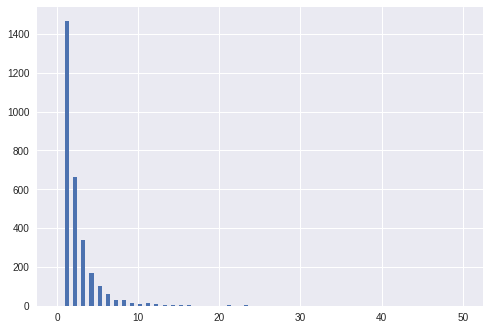

In [22]:
callersCntDF.hist(bins=100,range=(0,50))

Observation: The number of callers who reported more than 10 tickets is very less. And most of the callers have reported 1-2 tickets

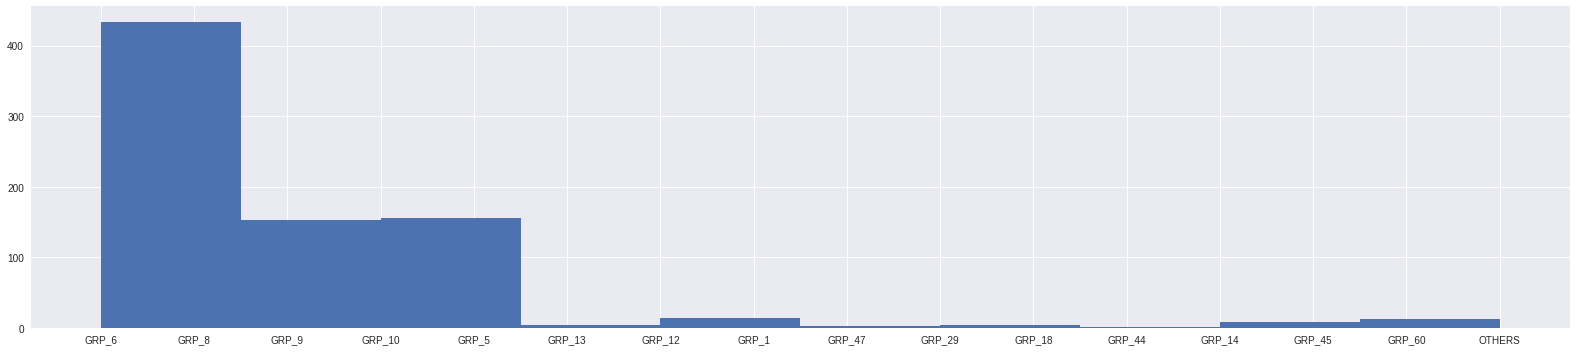

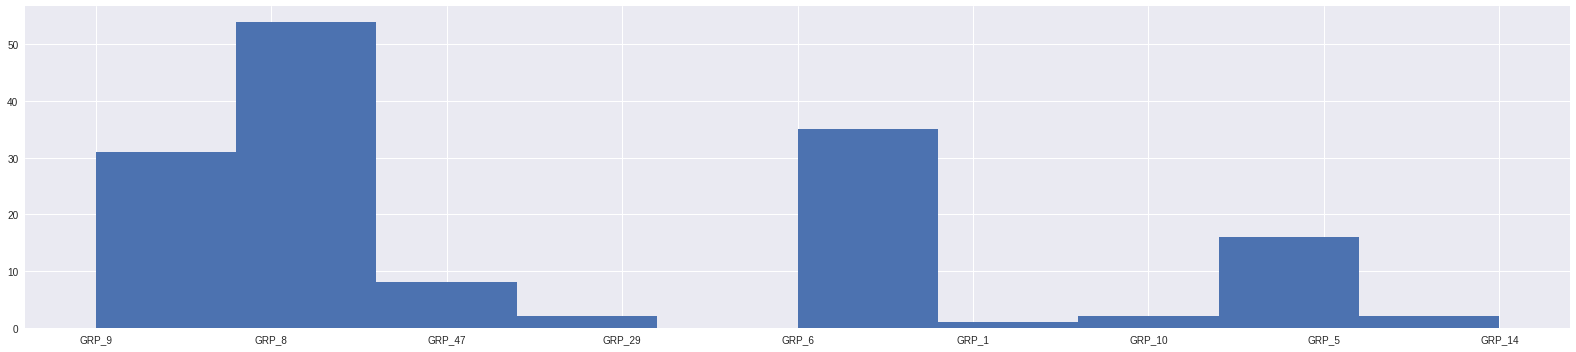

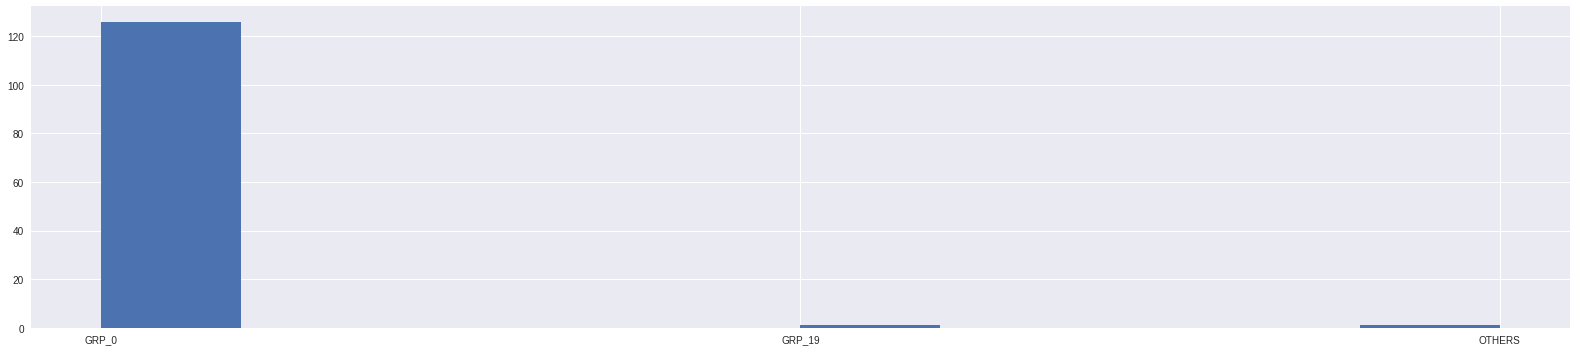

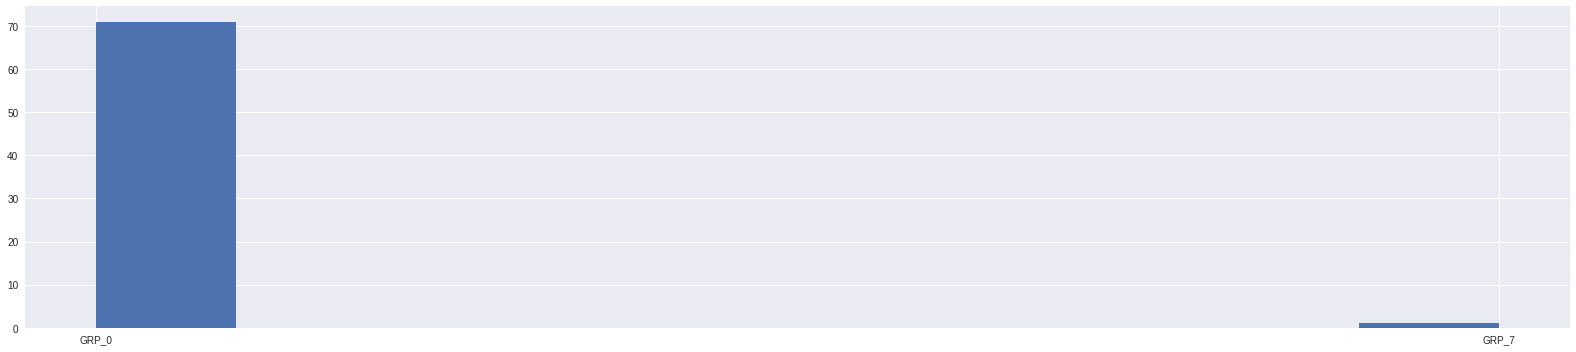

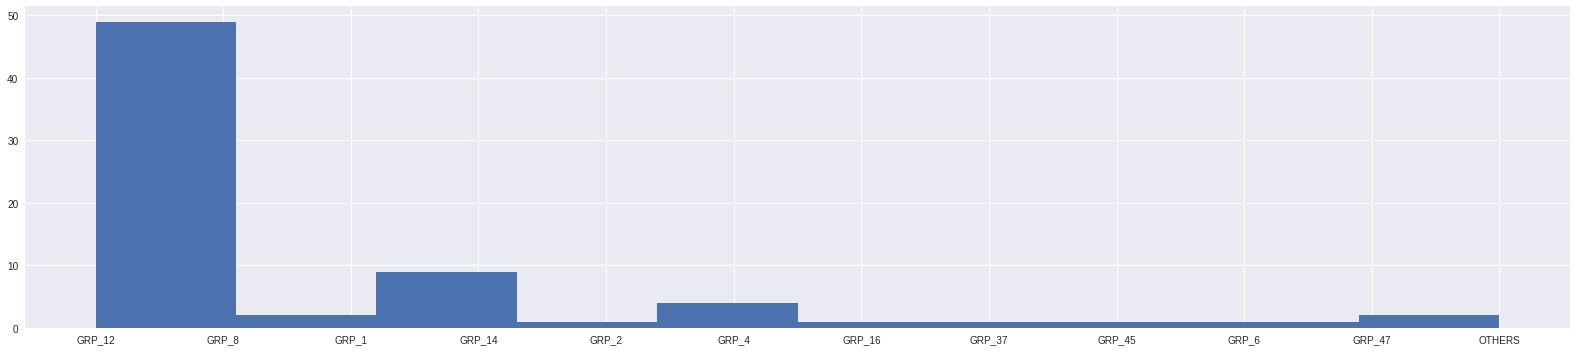

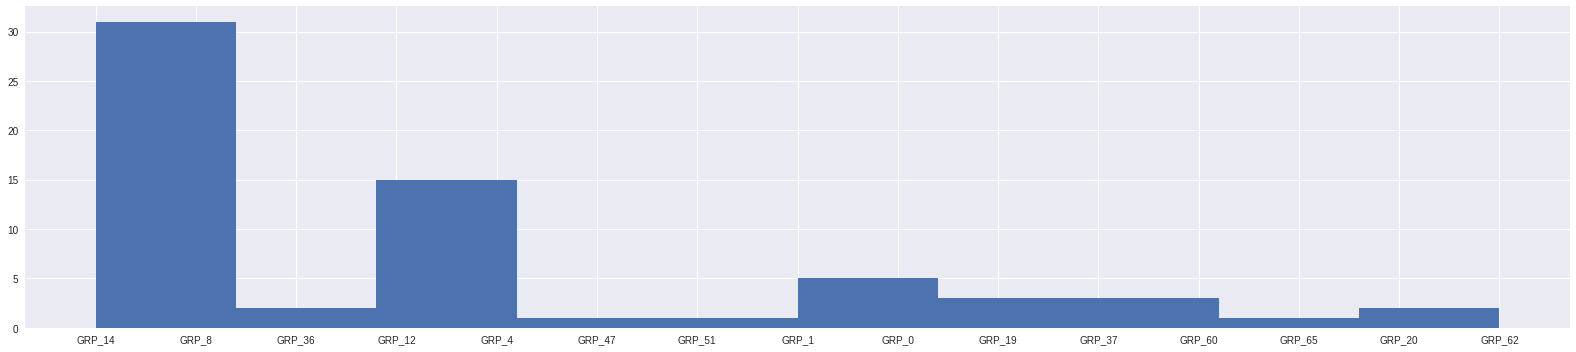

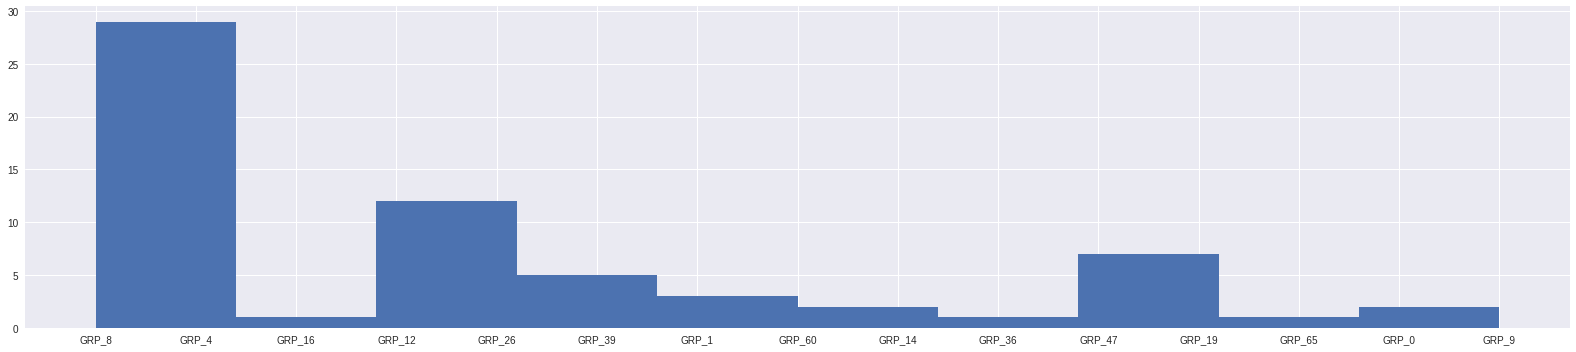

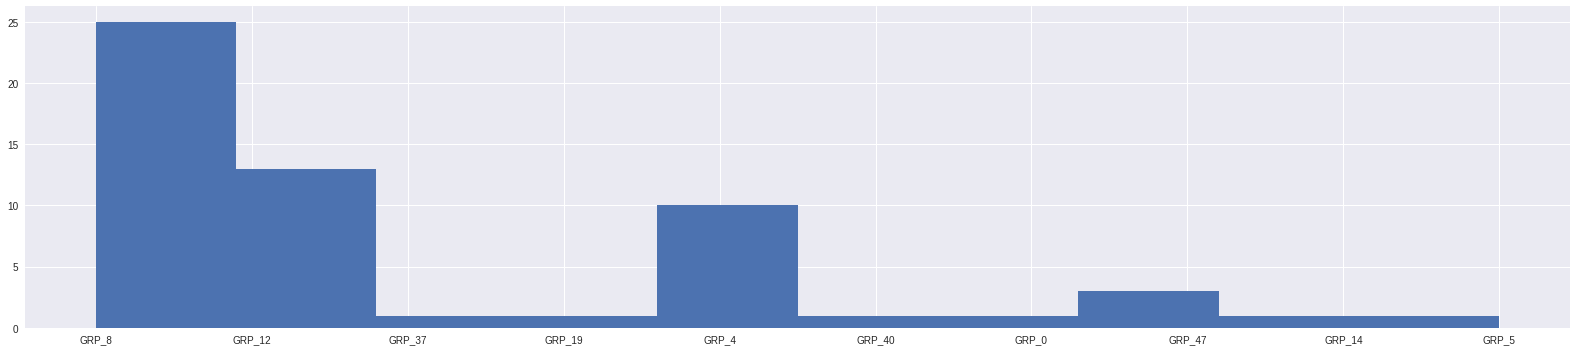

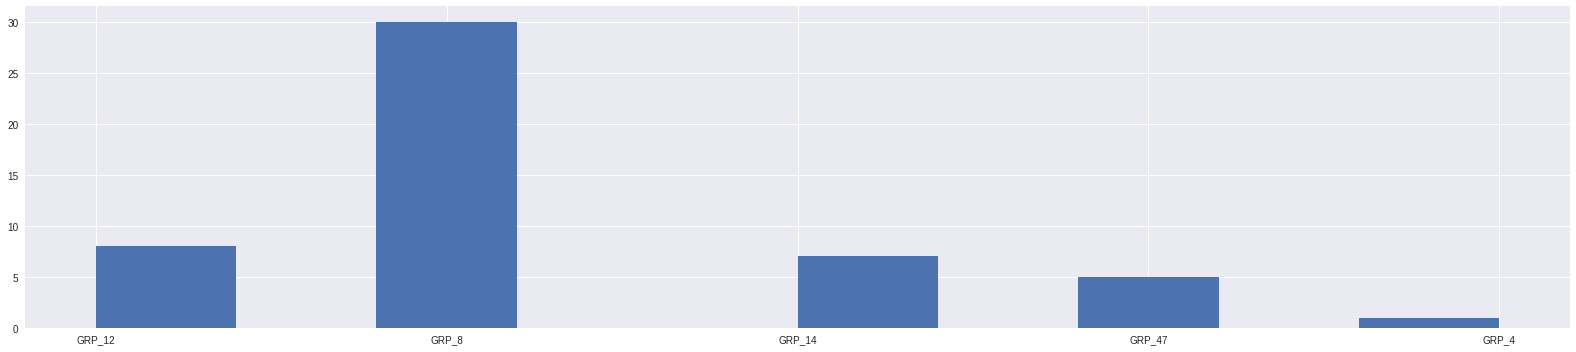

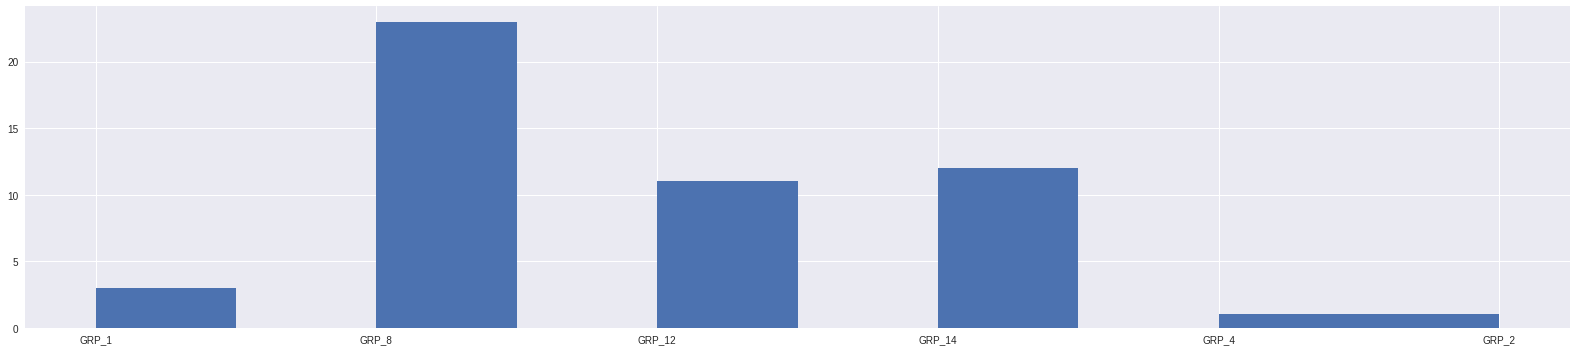

In [23]:
# look at distribution of Assignment Group for 10 most frequent callers
top_10_callers = callersCntDF.index[:10]
for caller in top_10_callers:
  assignment_groups = ticket_df[ticket_df['Caller']==caller]['Assignment group']
  plt.figure(figsize=(22,5))
  assignment_groups.hist()
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

#### Observation: 
* There are 2950 callers have been captured in the entire dataset. 
* The most frequent caller has raised tickets for a variety of Assignment groups.
* 15 callers are identified to be involved in raising tickets for multiple assignment groups


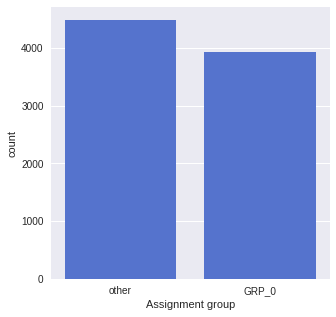

In [24]:
ticket_df_grp0 = ticket_df.copy()
ticket_df_grp0['Assignment group']=ticket_df_grp0['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = ticket_df_grp0['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=ticket_df_grp0, color='royalblue',order=descending_order)

#### Observation: 
* The above plot shows the distribution of samples of GRP_0 vs all other groups combined. 
* Large no of entries in GRP_0 (having count of 3976 entries) which account for ~50% of the data
* We need to fix the imbalance in the data using data augmentation techniques

In [25]:
ticket_df['sd_len'] = ticket_df['Short description'].astype(str).apply(len)
ticket_df['sd_word_count'] = ticket_df['Short description'].apply(lambda x: len(str(x).split()))
ticket_df['ld_len'] = ticket_df['Description'].astype(str).apply(len)
ticket_df['ld_word_count'] = ticket_df['Description'].apply(lambda x: len(str(x).split()))

In [26]:
ticket_df.head()

,Short description,Description,Caller,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0,11,2,206,33
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0,7,1,194,25
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0,18,5,87,11
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29,5,29,5
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12,2,12,2


In [27]:
ticket_df['sd_len'].describe()

count    8417.000000
mean     47.253059  
std      27.068818  
min      0.000000   
25%      26.000000  
50%      41.000000  
75%      62.000000  
max      159.000000 
Name: sd_len, dtype: float64

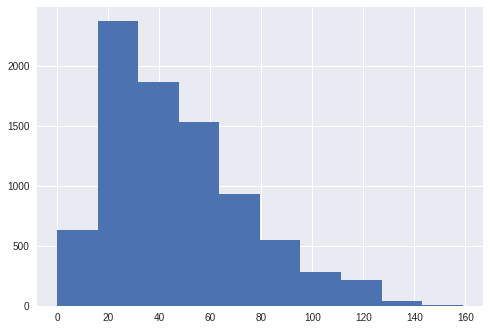

In [28]:
ticket_df['sd_len'].hist()

In [29]:
ticket_df['sd_len'].value_counts()[-20:]

131    3
127    3
133    3
125    3
145    2
141    2
137    2
144    2
135    2
159    2
138    1
2      1
151    1
140    1
1      1
136    1
149    1
134    1
142    1
150    1
Name: sd_len, dtype: int64

Description: There are some single character short descriptions as well. However majority of the short description is not beyound 62 characters

In [30]:
ticket_df['ld_len'].describe()

count    8417.000000 
mean     205.498753  
std      521.952353  
min      0.000000    
25%      42.000000   
50%      106.000000  
75%      203.000000  
max      13001.000000
Name: ld_len, dtype: float64

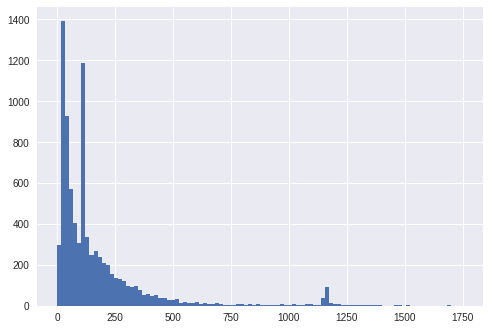

In [31]:
ticket_df['ld_len'].hist(bins=100, range=(0,1750))

In [32]:
ticket_df['ld_len'].value_counts()[-20:]

1347    1
1379    1
1387    1
1515    1
1659    1
1795    1
644     1
1839    1
4286    1
2293    1
388     1
468     1
516     1
532     1
564     1
588     1
596     1
612     1
628     1
0       1
Name: ld_len, dtype: int64

Description: There are some single character descriptions as well. However majority of the short description is not beyound 201 characters

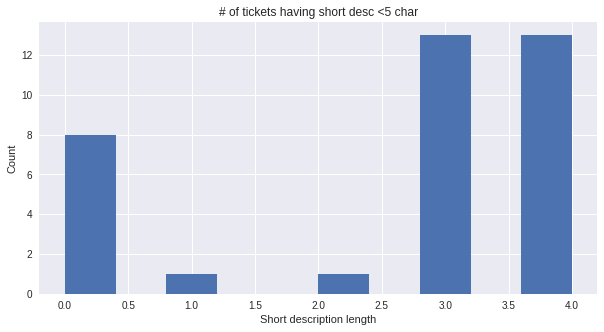

In [33]:
sd_len_FiveChar = ticket_df[ticket_df["sd_len"] < 5]
plt.xlabel('Short description length')
plt.ylabel('Count')
plt.title('# of tickets having short desc <5 char')
sd_len_FiveChar['sd_len'].hist(bins=10, figsize=(10,5))

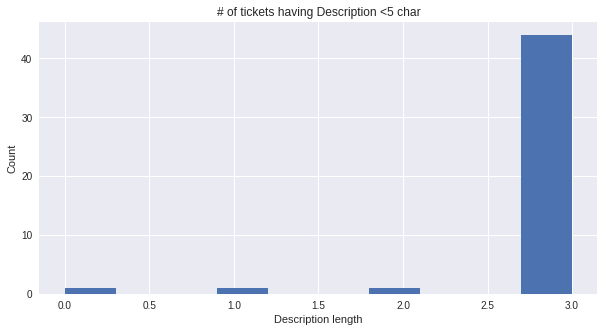

In [34]:
sd_len_FiveChar = ticket_df[ticket_df["ld_len"] < 5]
plt.xlabel('Description length')
plt.ylabel('Count')
plt.title('# of tickets having Description <5 char')
sd_len_FiveChar['ld_len'].hist(bins=10, figsize=(10,5))

In [35]:
ticket_df_temp =  ticket_df.copy()
ticket_df_temp['num_words'] = ticket_df['Description'].apply(lambda x : len(x.split()))
ticket_df_temp.describe()

,sd_len,sd_word_count,ld_len,ld_word_count,num_words
count,8417.000000,8417.000000,8417.000000,8417.000000,8417.000000
mean,47.253059,6.939290,205.498753,27.471902,27.471902
std,27.068818,4.133266,521.952353,65.319593,65.319593
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,4.000000,42.000000,6.000000,6.000000
50%,41.000000,6.000000,106.000000,11.000000,11.000000
75%,62.000000,9.000000,203.000000,28.000000,28.000000
max,159.000000,28.000000,13001.000000,1625.000000,1625.000000


Text(0.5, 1.0, 'Word distribution per bin')

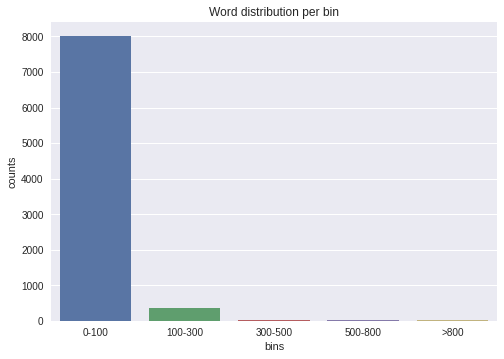

In [36]:
ticket_df_temp['bins']=pd.cut(ticket_df_temp.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = ticket_df_temp.groupby('bins').size().reset_index().rename(columns={0:'counts'})
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Observation: Most of the samples had word count within 100

Common class/methods for data cleansing 
* Convert each character in a sentence to lowercase character
* Remove HTML Tags
* Remove Email contacts
* Remove punctuations, hyperlinks
* Remove stopwords
* Remove common words like com, hello
* Remove New line characters
* Stemming was causing invalid words, hence used a lemmatizer

In [37]:
class PreProcessing:
    lemmatizer=""
    stemmer =""
    tokenizer=""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = LancasterStemmer()
        self.tokenizer = RegexpTokenizer(r'\w+')
    
    def data_clean(self, sentence):
      if pd.isnull(sentence):
        return sentence
      sentence= sentence.lower()
      sentence = ' '.join([w for w in sentence.split() if not self.is_valid_date(w)])
      sentence = re.sub(r"received from:",' ',sentence)
      sentence = re.sub(r"select the following link to view the disclaimer in an alternate language.",' ',sentence)
      sentence = re.sub(r"from:",' ',sentence)
      sentence = re.sub(r"to:",' ',sentence)
      sentence = re.sub(r"subject:",' ',sentence)
      sentence = re.sub(r"re:",' ',sentence)
      sentence = re.sub(r"fw:",' ',sentence)
      sentence = re.sub(r"sent:",' ',sentence)
      sentence = re.sub(r"ic:",' ',sentence)
      sentence = re.sub(r"cc:",' ',sentence)
      sentence = re.sub(r"bcc:",' ',sentence)
      #Remove email 
      sentence = re.sub(r'\S*@\S*\s?', '', sentence)
      # Remove underscores
      sentence = re.sub(r'\_',' ', sentence)

      # Remove new line characters 
      sentence = re.sub(r'\n',' ',sentence)
      # Remove hashtag while keeping hashtag sentence
      sentence = re.sub(r'#','', sentence)
      #& 
      sentence = re.sub(r'&;?', 'and',sentence)
      # Remove HTML special entities (e.g. &amp;)
      sentence = re.sub(r'\&\w*;', '', sentence)
      # Remove hyperlinks
      sentence = re.sub(r'https?:\/\/.*\/\w*', '', sentence)  
      # Remove characters beyond Readable formart by Unicode:
      sentence= ''.join(c for c in sentence if c <= '\uFFFF') 
      sentence = sentence.strip()
      # Remove unreadable characters  (also extra spaces)
      sentence = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", sentence).split())

      # Single character      
      sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
      sentence = sentence.strip()
      return sentence
    
    def is_valid_date(self,date_str):
      try:
        parser.parse(date_str)
        return True
      except:
        return False
    
    def mergeColumns(self, df):
        df['desc']=df['Short description'] + " " + df['Description']
        df.drop("Short description", axis=1, inplace=True)
        df.drop("Description", axis=1, inplace=True)
        df.drop("Caller", axis=1, inplace=True)
        return df

    def remove_punctuation(self, sentence):
      try:
        no_punct = "".join([c for c in sentence if c not in string.punctuation])
        return no_punct
      except:
        print("remove_punctuation: sentence,",sentence)
        return sentence

    def make_tokens(self, sentence):
      return self.tokenizer.tokenize(sentence.lower())

    def remove_stopwords(self, words):
      return [w for w in words if w not in stopwords.words('english')]

    def word_lemmatize(self, words):
      return [self.lemmatizer.lemmatize(item) for item in words]


preProcessing=PreProcessing()

In [38]:
# merging two description columns and doing cleaning
ticket_df=preProcessing.mergeColumns(ticket_df)
ticket_df['desc_clean'] = ticket_df['desc'].apply(preProcessing.data_clean)

In [39]:
ticket_df.head()

,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count,desc,desc_clean
0,GRP_0,11,2,206,33,login issue -verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,login issue verified user details employee and manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved
1,GRP_0,7,1,194,25,"outlook \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",outlook hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind
2,GRP_0,18,5,87,11,cant log in to vpn \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,cant log in to vpn hi cannot log on to vpn best
3,GRP_0,29,5,29,5,unable to access hr_tool page unable to access hr_tool page,unable to access hr tool page unable to access hr tool page
4,GRP_0,12,2,12,2,skype error skype error,skype error skype error


In [40]:
ticket_df['desc_punct'] = ticket_df['desc_clean'].map(preProcessing.remove_punctuation)
ticket_df['desc_token'] = ticket_df['desc_punct'].map(preProcessing.make_tokens)
ticket_df['desc_stop'] = ticket_df['desc_token'].map(preProcessing.remove_stopwords)
ticket_df['desc_lemma'] = ticket_df['desc_stop'].map(preProcessing.word_lemmatize)

In [41]:
ticket_df.head()

,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count,desc,desc_clean,desc_punct,desc_token,desc_stop,desc_lemma
0,GRP_0,11,2,206,33,login issue -verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,login issue verified user details employee and manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,login issue verified user details employee and manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,"[login, issue, verified, user, details, employee, and, manager, name, checked, the, user, name, in, ad, and, reset, the, password, advised, the, user, to, login, and, check, caller, confirmed, that, he, was, able, to, login, issue, resolved]","[login, issue, verified, user, details, employee, manager, name, checked, user, name, ad, reset, password, advised, user, login, check, caller, confirmed, able, login, issue, resolved]","[login, issue, verified, user, detail, employee, manager, name, checked, user, name, ad, reset, password, advised, user, login, check, caller, confirmed, able, login, issue, resolved]"
1,GRP_0,7,1,194,25,"outlook \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",outlook hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,outlook hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,"[outlook, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, outlook, calendar, can, somebody, please, advise, how, to, correct, this, kind]","[outlook, hello, team, meetings, skype, meetings, etc, appearing, outlook, calendar, somebody, please, advise, correct, kind]","[outlook, hello, team, meeting, skype, meeting, etc, appearing, outlook, calendar, somebody, please, advise, correct, kind]"
2,GRP_0,18,5,87,11,cant log in to vpn \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,cant log in to vpn hi cannot log on to vpn best,cant log in to vpn hi cannot log on to vpn best,"[cant, log, in, to, vpn, hi, cannot, log, on, to, vpn, best]","[cant, log, vpn, hi, cannot, log, vpn, best]","[cant, log, vpn, hi, cannot, log, vpn, best]"
3,GRP_0,29,5,29,5,unable to access hr_tool page unable to access hr_tool page,unable to access hr tool page unable to access hr tool page,unable to access hr tool page unable to access hr tool page,"[unable, to, access, hr, tool, page, unable, to, access, hr, tool, page]","[unable, access, hr, tool, page, unable, access, hr, tool, page]","[unable, access, hr, tool, page, unable, access, hr, tool, page]"
4,GRP_0,12,2,12,2,skype error skype error,skype error skype error,skype error skype error,"[skype, error, skype, error]","[skype, error, skype, error]","[skype, error, skype, error]"


In [42]:
combined_desc = ticket_df['desc_stop'].values.tolist()

In [43]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(combined_desc))

In [44]:
all_words = []
for i in range(len(data_words)): #Traversing through the main list
  for j in range (len(data_words[i])): #Traversing through each sublist
    all_words.append(data_words[i][j])

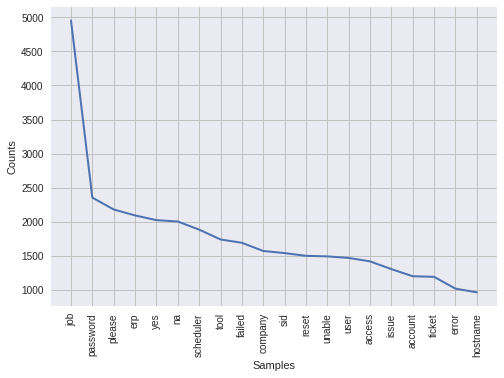

In [45]:
word_freq = nltk.FreqDist(all_words)
word_freq.plot(20)

In [46]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)    
print(data_words_bigrams[1])

['outlook', 'hello', 'team', 'meetings', 'skype', 'meetings', 'etc', 'appearing', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


In [47]:
wordclouds=' '.join(map(str, data_words_bigrams)) 

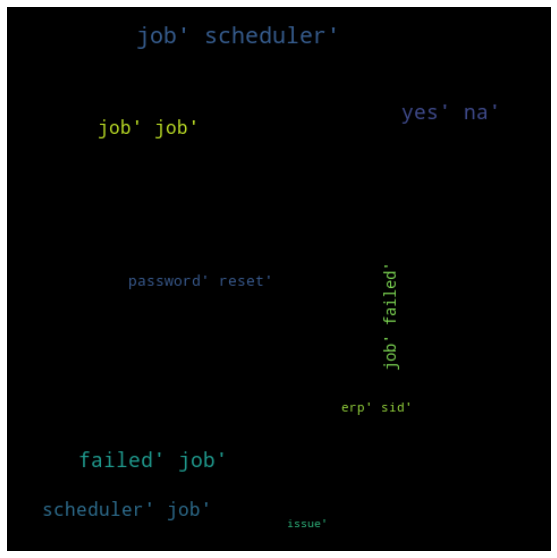

In [48]:
wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(wordclouds)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

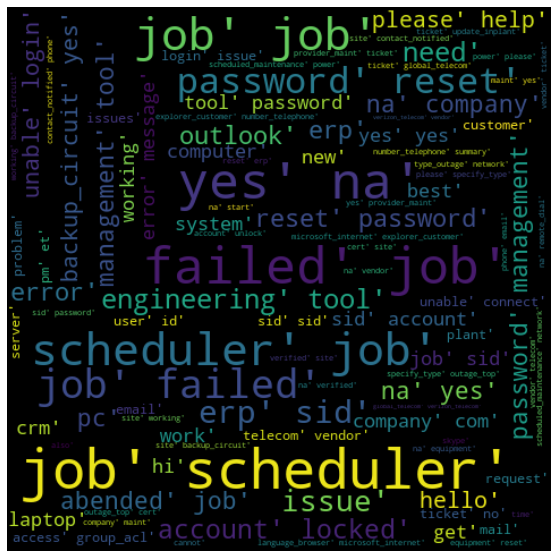

In [49]:
wordcloud_2 = WordCloud(width=480, height=480, max_words=100).generate(wordclouds)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [50]:
def wordcloud_grp(f, x):
    wordclouds_by_grp =' '.join(map(str, f))
    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=50).generate(wordclouds_by_grp)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 50 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

In [51]:
value = targetClassCnt.sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'GRP_16', 'GRP_31', 'GRP_7',
       'GRP_17', 'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41', 'GRP_30',
       'GRP_15', 'GRP_42', 'GRP_20', 'GRP_45', 'GRP_1', 'GRP_22', 'GRP_11',
       'GRP_21', 'GRP_47', 'GRP_62', 'GRP_48', 'GRP_23', 'GRP_39', 'GRP_27',
       'GRP_60', 'GRP_37', 'GRP_44', 'GRP_36', 'GRP_50', 'GRP_65', 'GRP_53',
       'GRP_52', 'GRP_55', 'GRP_51', 'GRP_46', 'GRP_59', 'GRP_49', 'GRP_43',
       'GRP_32', 'GRP_66', 'GRP_68', 'GRP_58', 'GRP_56', 'GRP_63', 'GRP_38',
       'GRP_54', 'GRP_57', 'GRP_71', 'GRP_72', 'GRP_69', 'GRP_67', 'GRP_64',
       'GRP_35', 'GRP_70', 'GRP_61', 'GRP_73'],
      dtype='object')

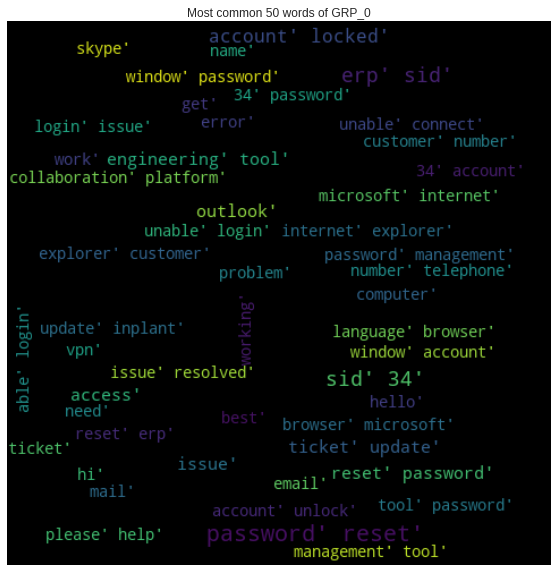

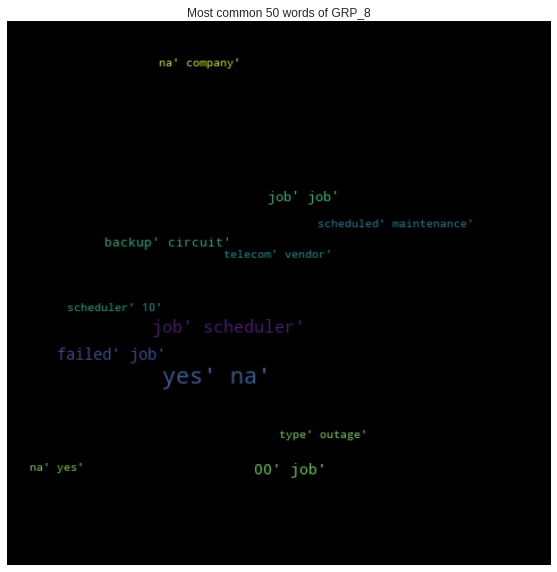

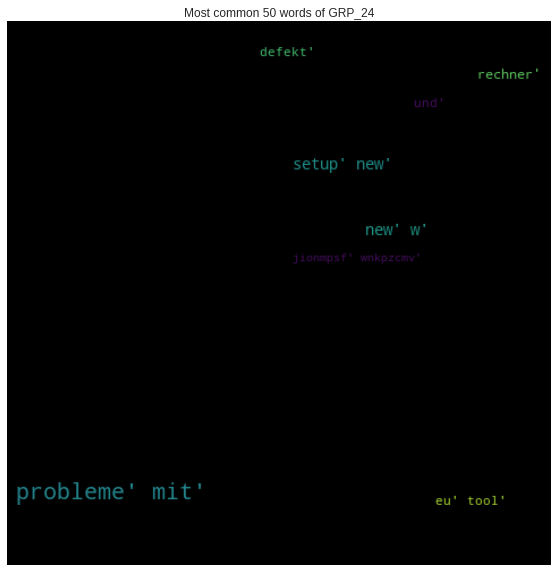

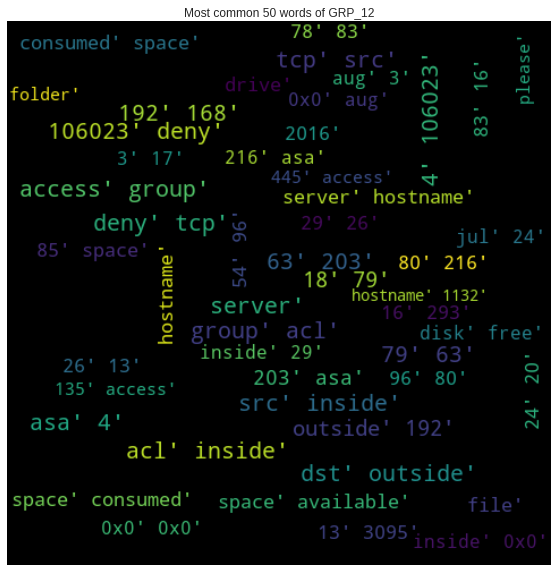

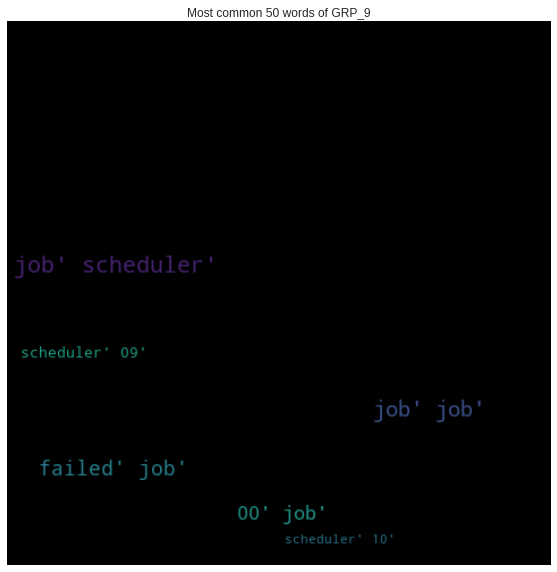

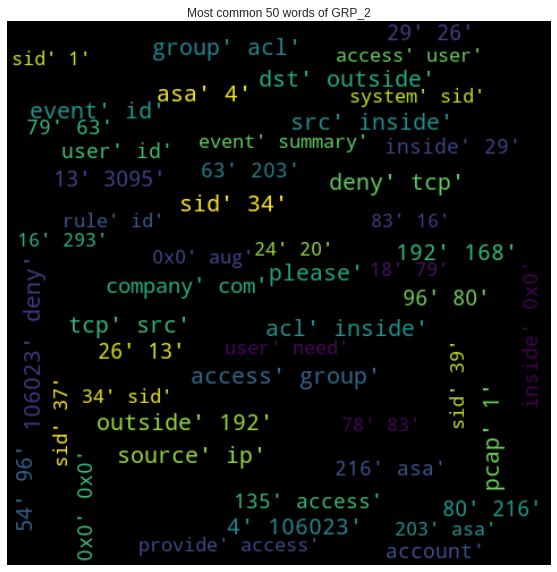

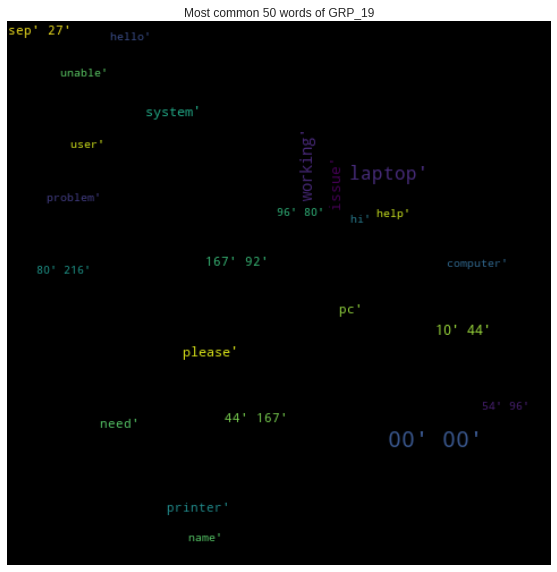

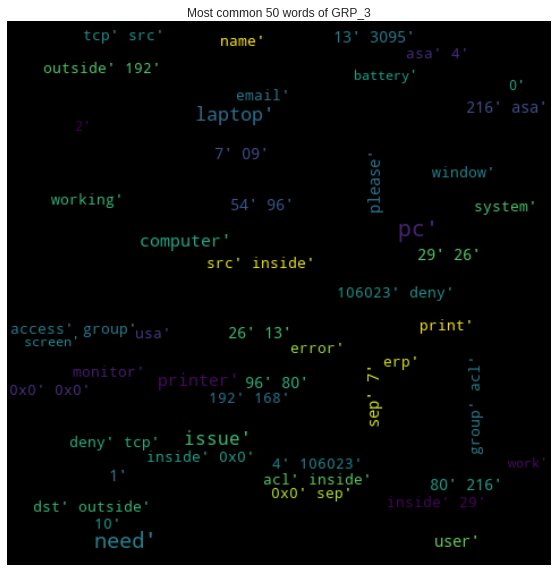

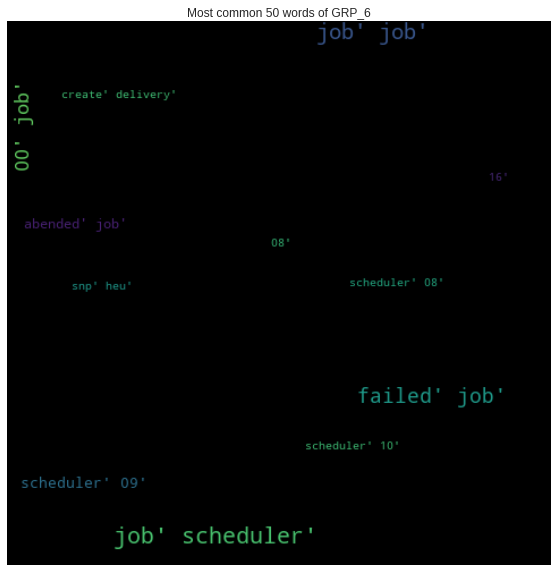

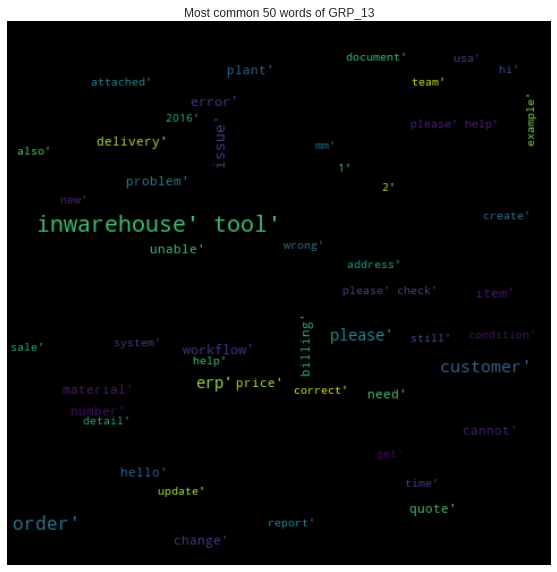

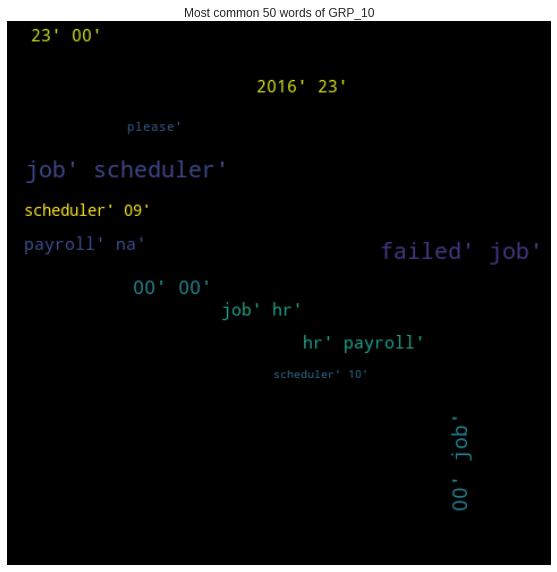

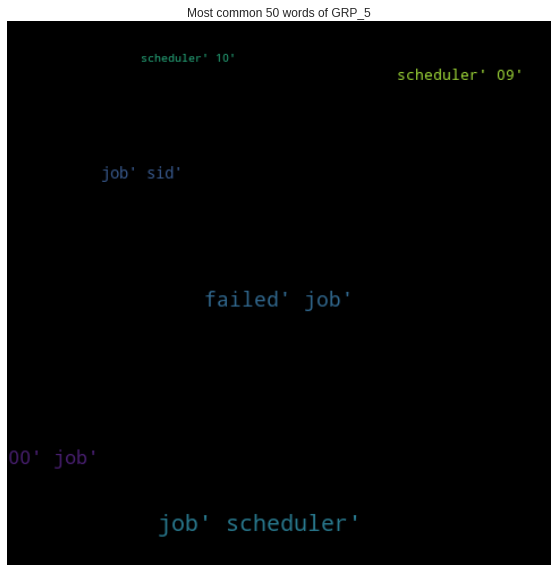

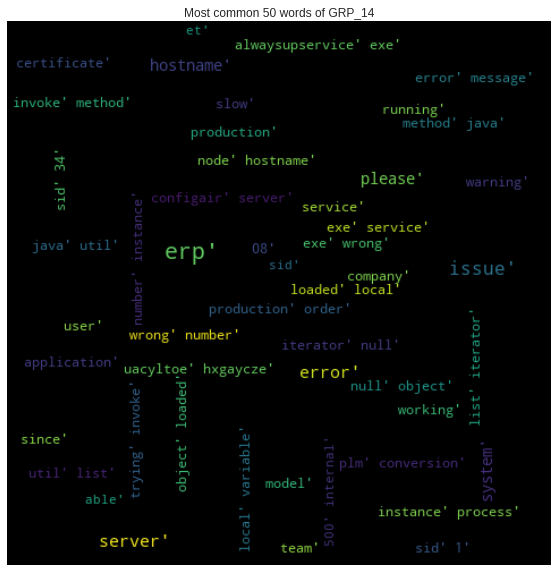

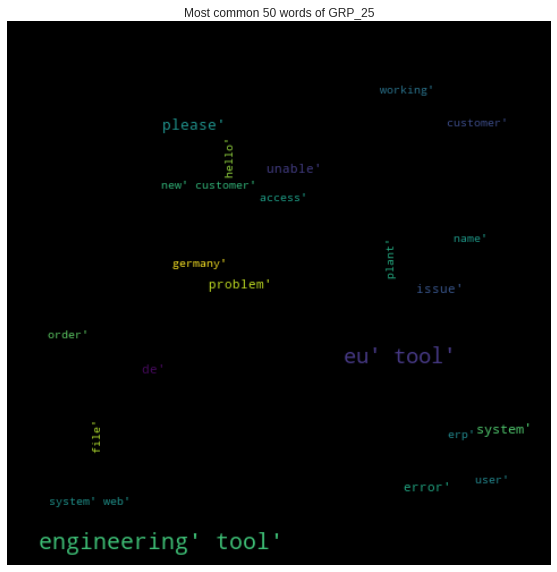

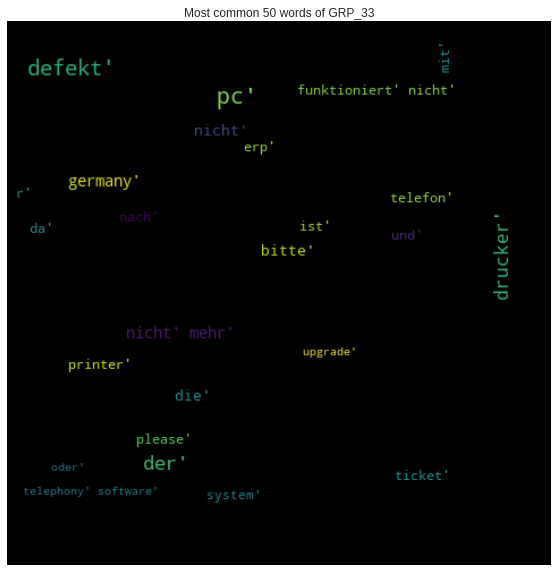

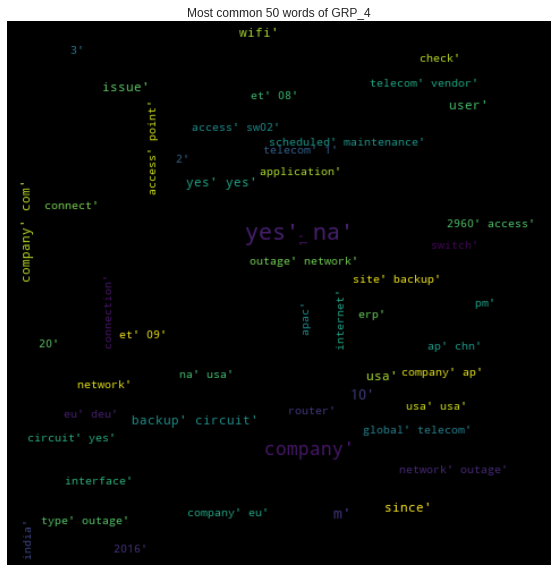

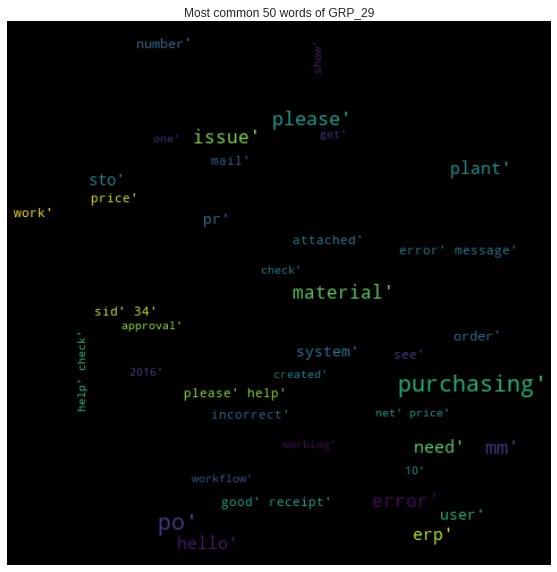

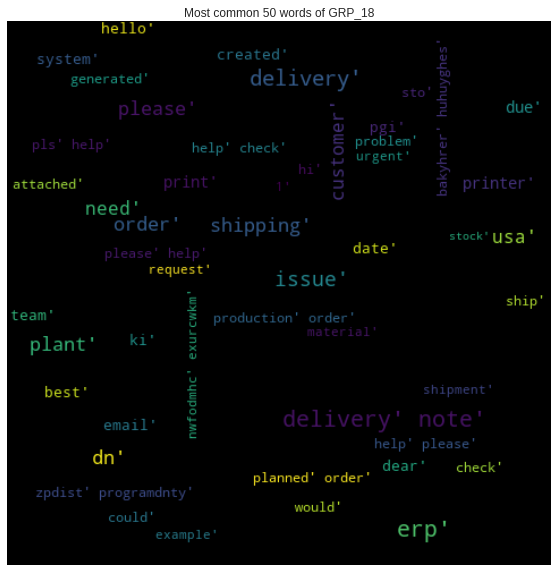

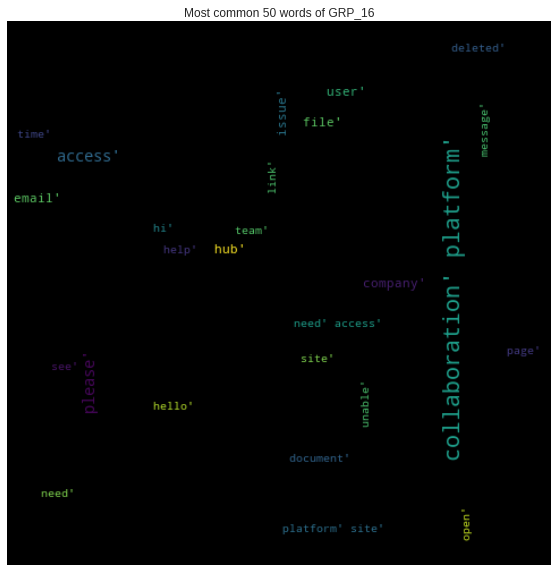

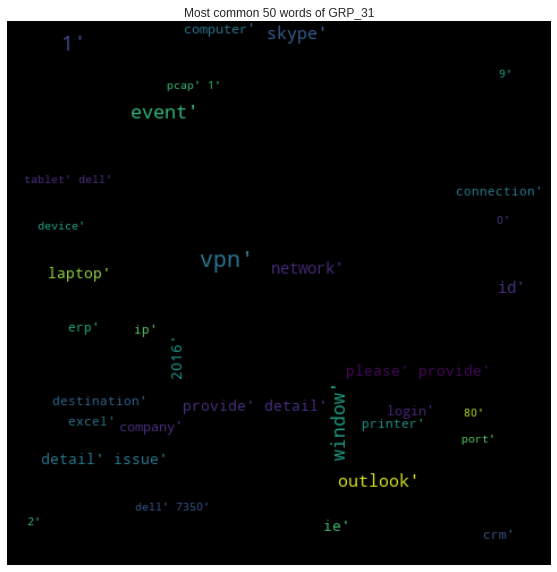

In [52]:
for i in range(20):

    Grp = ticket_df[ticket_df ['Assignment group'] == value[i]]
    Grp = Grp['desc_lemma']
    wordcloud_grp(Grp,value[i])

In [53]:
X=ticket_df['desc_lemma'].apply(lambda x: ' '.join(x))
y=ticket_df['Assignment group']

In [54]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(lowercase=True, stop_words="english")
# X = vectorizer.fit_transform(X)

In [55]:
le = LabelEncoder() 
le.fit(y)
y = le.transform(y)

In [56]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(binary=False, norm='l2', use_idf=True, smooth_idf=True, min_df=1,max_df=1.0,max_features=None,ngram_range=(1,1), stop_words='english')
tfidf.fit(X)
X = tfidf.transform(X)

In [57]:
print(X.shape)

(8417, 18838)


In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = SelectKBest(score_func=chi2,k=5000).fit_transform(X, y)

In [59]:
print(X.shape)

(8417, 5000)


In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [61]:
def precision_recall_fscore_support_roc_auc(model, y_test,X_test):
  y_pred = model.predict(X_test)

  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
  print("Precision: ",precision)
  print("Recall: ",recall)
  print('F1 score: ',f1_score)

  y_proba = model.predict_proba(X_test)

  print("roc_auc value: ",roc_auc_score(y_test, y_proba, labels = clf.classes_, average='macro', multi_class='ovo'))
  cf_matrix = confusion_matrix(y_test, y_pred)
  # print('Confusion matrix:\n %s' % (cf_matrix))
  plt.subplots(figsize=(25,10))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12}, cmap='Oranges')

train acc:  0.6683075878458665
test acc:  0.6203483768804434
Precision:  0.6203483768804434
Recall:  0.6203483768804434
F1 score:  0.6203483768804434
roc_auc value:  0.8451686259772785


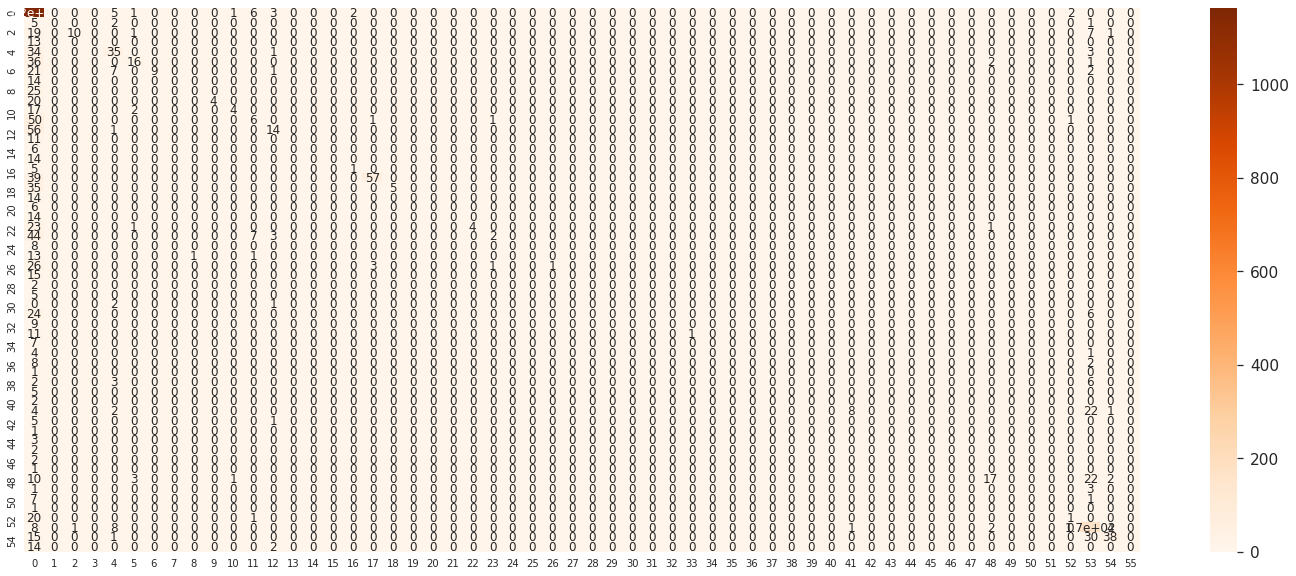

In [62]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.9845527075199457
test acc:  0.6543942992874109
Precision:  0.6543942992874109
Recall:  0.6543942992874109
F1 score:  0.6543942992874109
roc_auc value:  0.776114134025569


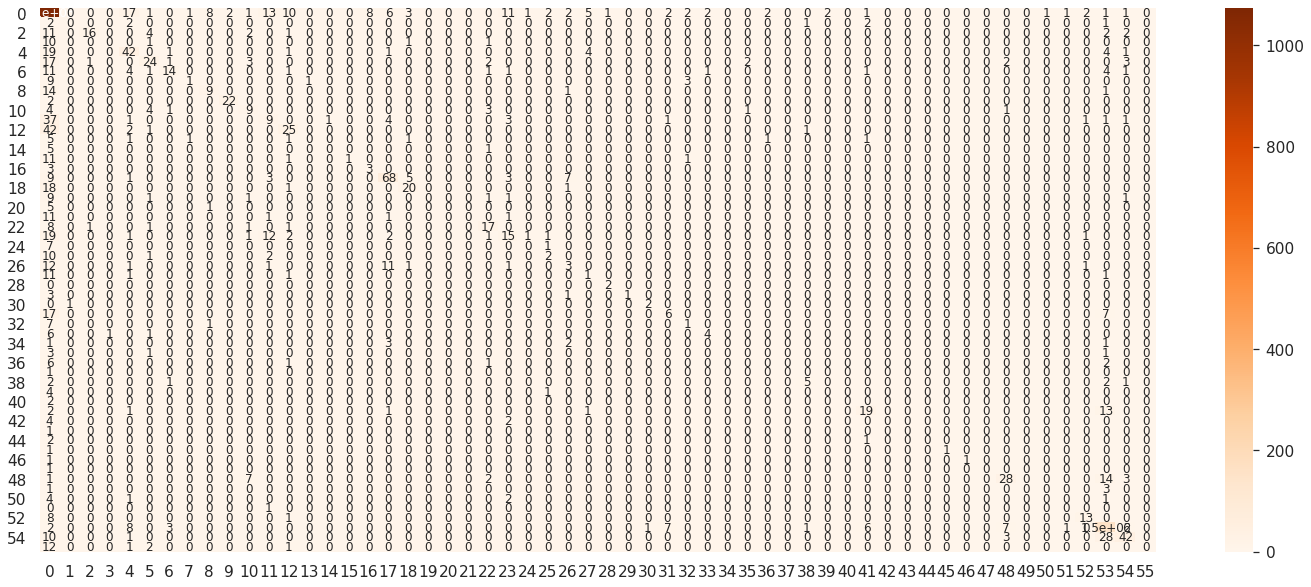

In [63]:
clf = RandomForestClassifier(n_estimators = 20, random_state=1,max_features=1.0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.8168392463079274
test acc:  0.61243072050673
Precision:  0.61243072050673
Recall:  0.61243072050673
F1 score:  0.61243072050673
roc_auc value:  0.6610127528851476


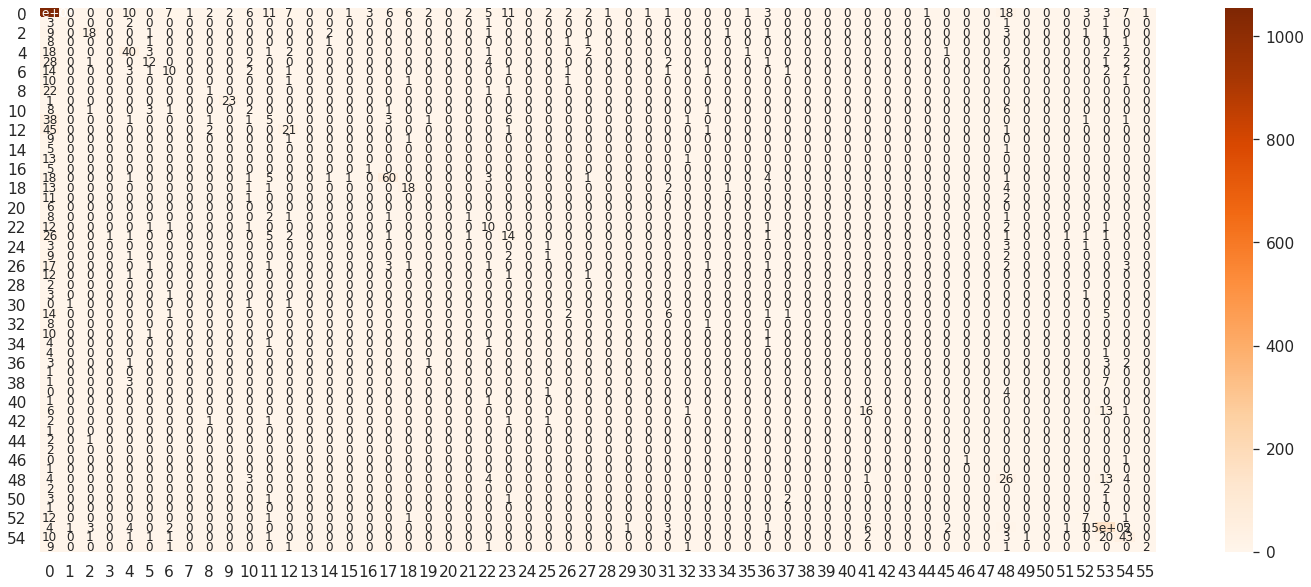

In [64]:
estimators = [
     ('rf', KNeighborsClassifier(n_neighbors= 5, weights = 'distance')),
     ('svr',SVC(C=2,gamma = 'auto', kernel= 'poly', degree=2),
     LogisticRegression(solver="liblinear"))]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=RandomForestClassifier(n_estimators = 20, random_state=1,max_features=1.0)).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.9903242233916143
test acc:  0.6025336500395883
Precision:  0.6025336500395883
Recall:  0.6025336500395883
F1 score:  0.6025336500395883
roc_auc value:  0.6310389468387355


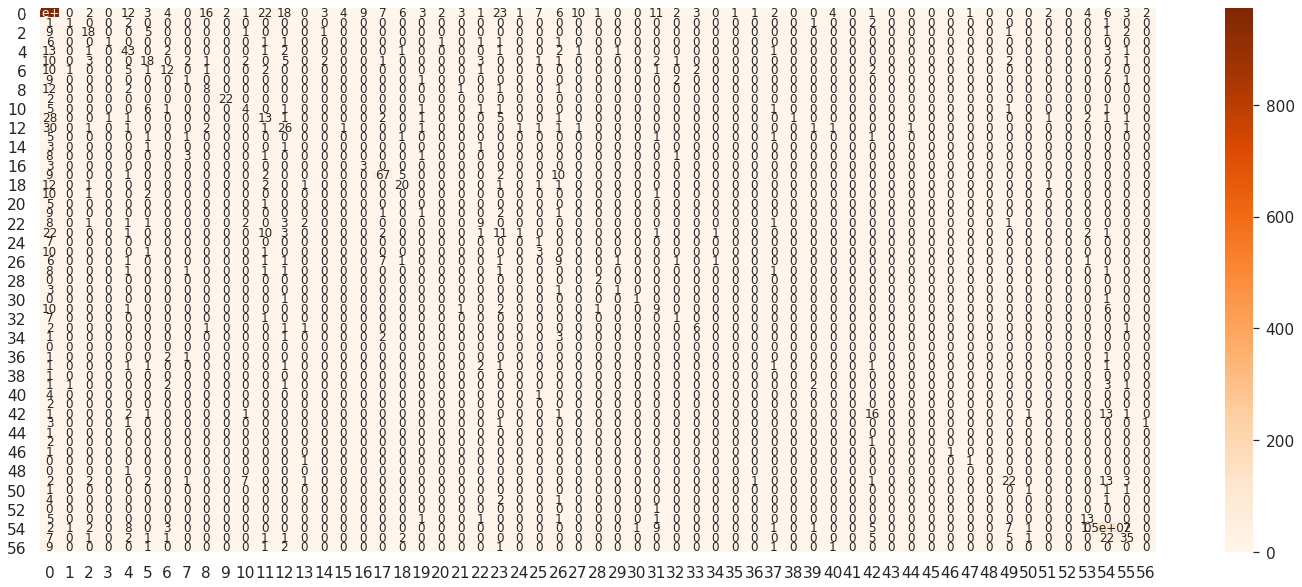

In [65]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1).fit(X_train, y_train)
print('train acc: ',dTree.score(X_train,y_train))
print('test acc: ',dTree.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(dTree,y_test,X_test)

train acc:  0.9877779663894076
test acc:  0.6492478226444972
Precision:  0.6492478226444972
Recall:  0.6492478226444972
F1 score:  0.6492478226444972
roc_auc value:  0.8023923777332377


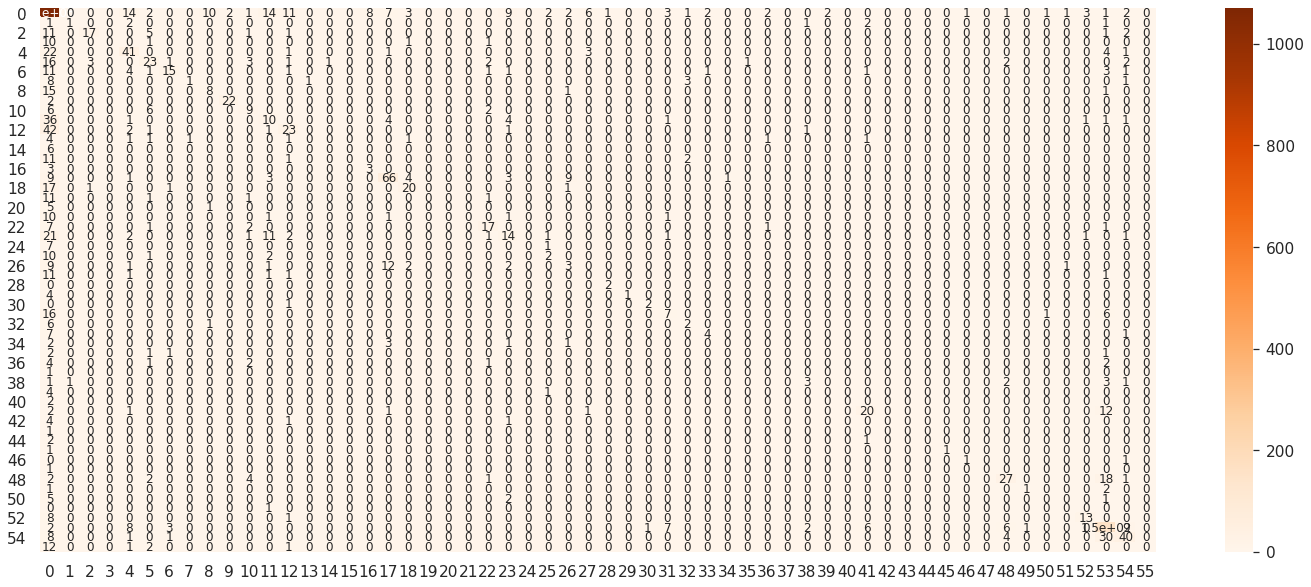

In [66]:
clf = BaggingClassifier(base_estimator=dTree, n_estimators=30,random_state=1).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.04702087930741809
test acc:  0.045526524148851936
Precision:  0.045526524148851936
Recall:  0.045526524148851936
F1 score:  0.045526524148851936
roc_auc value:  0.50924709824765


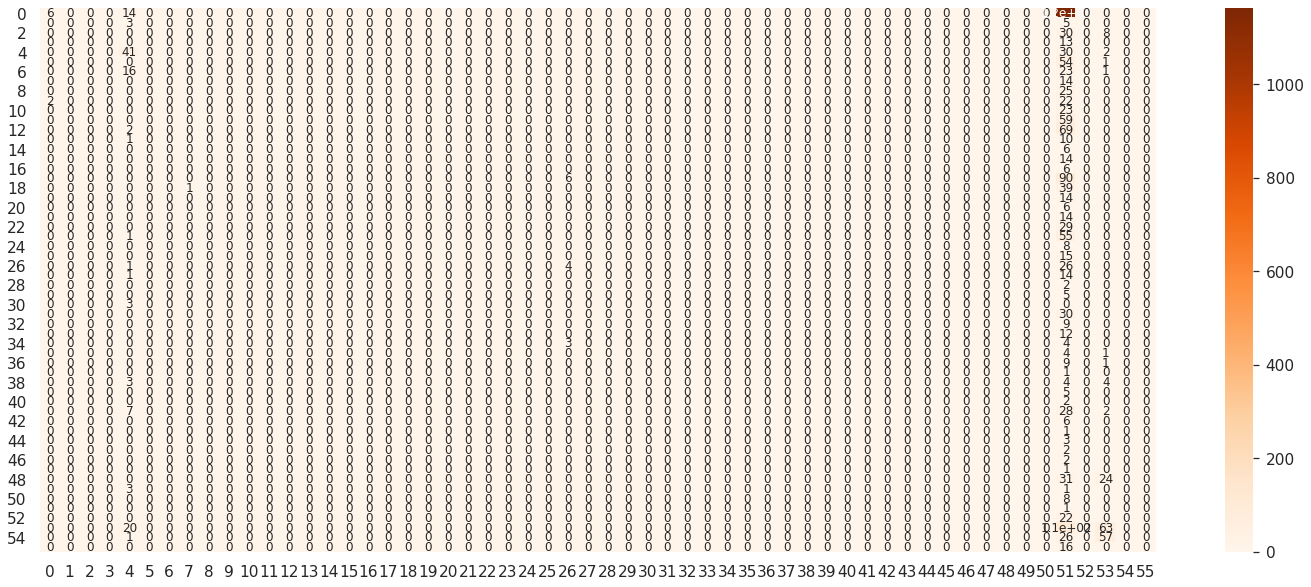

In [67]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.8066542182991003
test acc:  0.6444972288202692
Precision:  0.6444972288202692
Recall:  0.6444972288202692
F1 score:  0.6444972288202692
roc_auc value:  0.8917280703051754


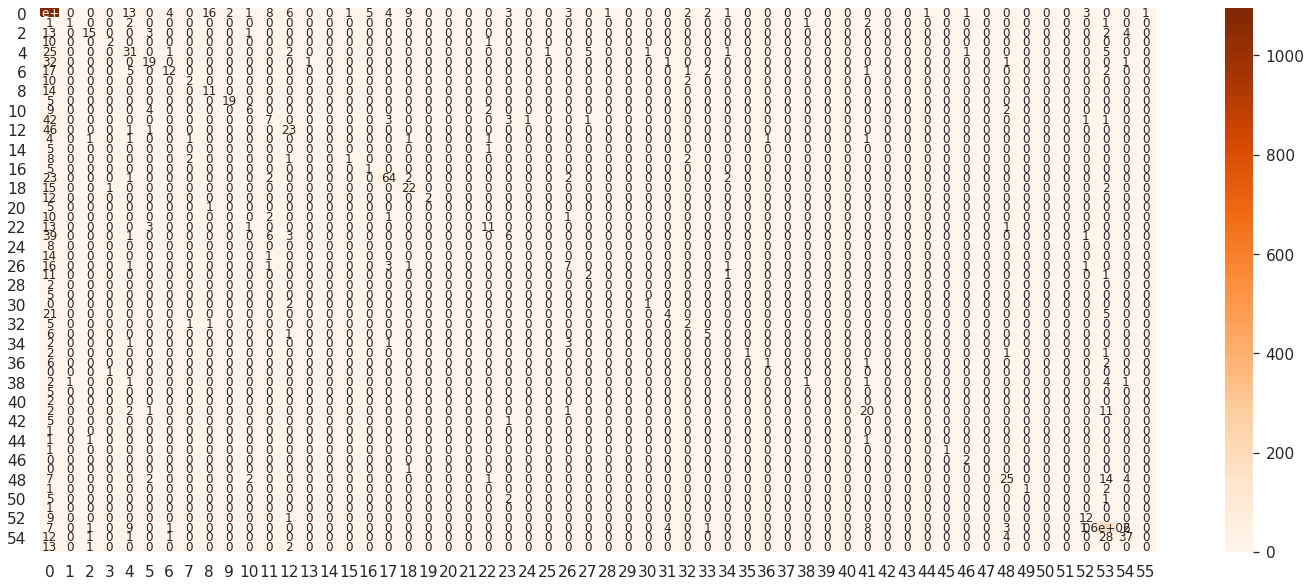

In [68]:
model = XGBClassifier().fit(X_train, y_train)
print('train acc: ',model.score(X_train,y_train))
print('test acc: ',model.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(model,y_test,X_test)

From the confusion matrix we observe many groups are misclassified as GRP_0. May be due to similarity between the corpus.